**Data centres - hyperscaler analysis**

Notebook contains efforts to identify future grid pressure sites based on long term development requests received by the UK Power Network by data centre development.

Data sources:
1. Data centres map - sent by Joe
2. Long Term Development Statement (LTDS) Table 6 New Connection Interest - via UK Power Networks at https://ukpowernetworks.opendatasoft.com/explore/dataset/ltds-table-6-interest-connections/information/?sort=-id
- This describes all new connection interest at each Primary substation, describing a forecast of load on the network and envisioned network developments
3. Local authority boundaries - via GADM


Methodology:

The idea is that we want to see the impact of data centres, especially hyperscalers, on the UK power grid. The location of each data centre is first linked to its nearest power station, and then requests received by each station are filtered according to those exceeding 30MWh. This is naturally slightly presumptuous so might be worth reassessing in future to see if there's a way to figure out more specifically who's putting requests in so they can be more concretely linked to data centres. These are then grouped by local authority to work out which local authorities are facing significant power station capacity requests and what this means for the authorities Total New Capacity (MVA).

Last edit: 18-09-2025

In [1]:
# Import packages
import pandas as pd
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely import wkt
import numpy as np

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load files
file_path = "/content/drive/My Drive/uk_datacentermap.csv"
uk_df = pd.read_csv(file_path)

shp_path = "/content/drive/My Drive/LAD_DEC_2023_UK_BFE.shp"
uk_shape = gpd.read_file(shp_path)


In [6]:
# Identifying hyperscalers
hyperscaler_df = uk_df[uk_df['type'] == 'Hyperscaler'].copy()

In [7]:
hyperscaler_df

,name,id,parent_id,company_name,company_id,stage,type,latitude,longitude,address,postal,city,market,state,country,power_mw,pue,year_operational
16,Amazon AWS - Houghton Regis DC1,14713,14712.0,Amazon AWS,1569,Planned,Hyperscaler,51.919645,-0.496774,Chantry Way,LU4 9UF,Houghton Regis,Luton,NaN,United Kingdom,NaN,NaN,NaN
17,Amazon AWS - Houghton Regis DC2,14714,14712.0,Amazon AWS,1569,Planned,Hyperscaler,51.918705,-0.495186,Chantry Way,LU4 9UF,Houghton Regis,Luton,NaN,United Kingdom,NaN,NaN,NaN
18,Amazon AWS LHR - Bracknell,10708,0.0,Amazon AWS,1569,Operational,Hyperscaler,51.413835,-0.782170,Cain Road,RG12 1JE,Bracknell,Berkshire,NaN,United Kingdom,NaN,NaN,NaN
19,Amazon AWS LHR - Didcot,10707,0.0,Amazon AWS,1569,Operational,Hyperscaler,51.617276,-1.261593,1 Milton Road,OX11 7GN,Didcot,Oxfordshire,NaN,United Kingdom,NaN,NaN,NaN
20,Amazon AWS LHR - Ridgeway,10709,0.0,Amazon AWS,1569,Planned,Hyperscaler,51.513786,-0.510191,"Ridgeway Distribution Center, The Ridgeway",SL0 9JQ,Iver,London,NaN,United Kingdom,NaN,NaN,NaN
21,Amazon AWS LHR - Swindon,10706,0.0,Amazon AWS,1569,Operational,Hyperscaler,51.523933,-1.764446,Brimble Hill / Burderop,SN4 0QB,Swindon,Swindon,NaN,United Kingdom,NaN,NaN,NaN
218,Google North Weald,14157,0.0,Google,11577,Planned,Hyperscaler,51.717522,0.157445,"Merlin Way, North Weald Bassett",CM16 6HR,Epping,Essex,NaN,United Kingdom,NaN,NaN,NaN
219,Google Waltham Cross,14156,0.0,Google,11577,Under Construction,Hyperscaler,51.696401,-0.048918,"Theobalds Business Park, A10 & Lieutenant Elli...",EN8 8XH,Waltham Cross,London,NaN,United Kingdom,NaN,NaN,NaN
236,IBM Hursley Data Centre,13751,0.0,IBM,4158,Operational,Hyperscaler,51.025524,-1.396205,"Hursley Deer Park, Hursley Park Rd",SO21 2JN,Hursley,Southampton,NaN,United Kingdom,NaN,NaN,1977.0
237,IBM Warwick Data Centre,13664,0.0,IBM,4158,Operational,Hyperscaler,52.293069,-1.603025,Birmingham Rd,CV34 5AH,Warwick,Birmingham UK,NaN,United Kingdom,NaN,NaN,NaN


In [10]:
# Turning into a gdf
hyperscaler_gdf = gpd.GeoDataFrame(
    hyperscaler_df,
    geometry=gpd.points_from_xy(hyperscaler_df.longitude, hyperscaler_df.latitude),
    crs="EPSG:4326"
)

In [11]:
# Specifying the crs
uk_shape_proj = uk_shape.to_crs(epsg=27700)
hyperscaler_gdf_proj = hyperscaler_gdf.to_crs(epsg=27700)


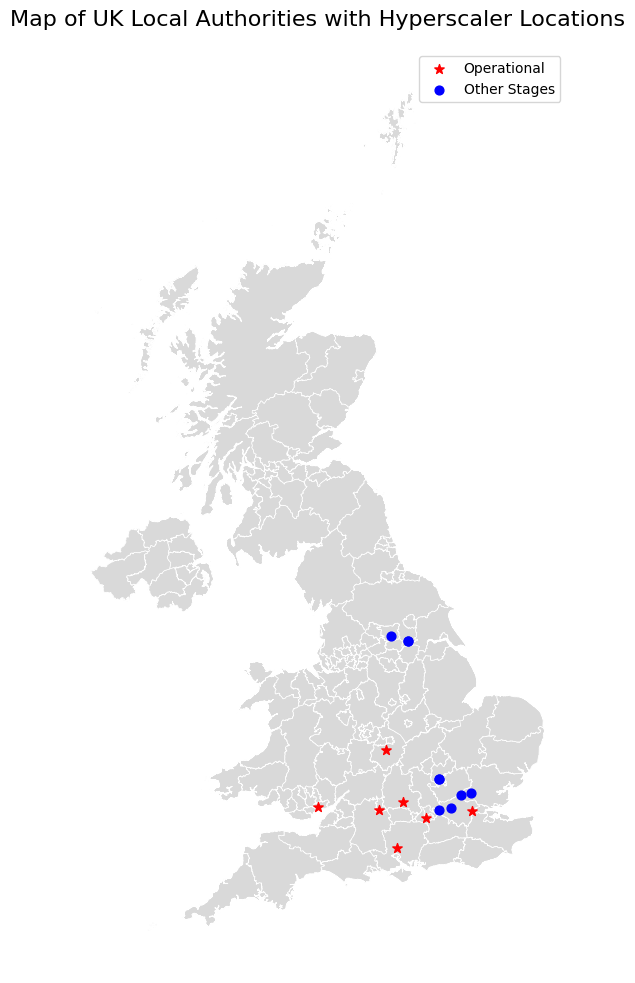

In [33]:
# Plotting hyperscalers
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

uk_shape_proj.plot(
    ax=ax,
    color='#d9d9d9',
    edgecolor='white',
    linewidth=0.5
)

operational_sites = hyperscaler_gdf_proj[hyperscaler_gdf_proj['stage'] == 'Operational']
other_sites = hyperscaler_gdf_proj[hyperscaler_gdf_proj['stage'] != 'Operational']

if not operational_sites.empty:
    operational_sites.plot(
        ax=ax,
        color='red',
        marker='*',
        markersize=50,
        label='Operational'
    )

if not other_sites.empty:
    other_sites.plot(
        ax=ax,
        color='blue',
        marker='o',
        markersize=40,
        label='Other Stages'
    )

ax.set_title('Map of UK Local Authorities with Hyperscaler Locations', fontsize=16)
ax.set_xlabel('Easting (meters)')
ax.set_ylabel('Northing (meters)')
plt.axis('off')
plt.legend()
plt.show()

In [14]:
# Turning into gdf
uk_gdf = gpd.GeoDataFrame(
    uk_df,
    geometry=gpd.points_from_xy(uk_df.longitude, uk_df.latitude),
    crs="EPSG:4326"
)

uk_shape_proj = uk_shape.to_crs(epsg=27700)
uk_gdf_proj = uk_gdf.to_crs(epsg=27700)

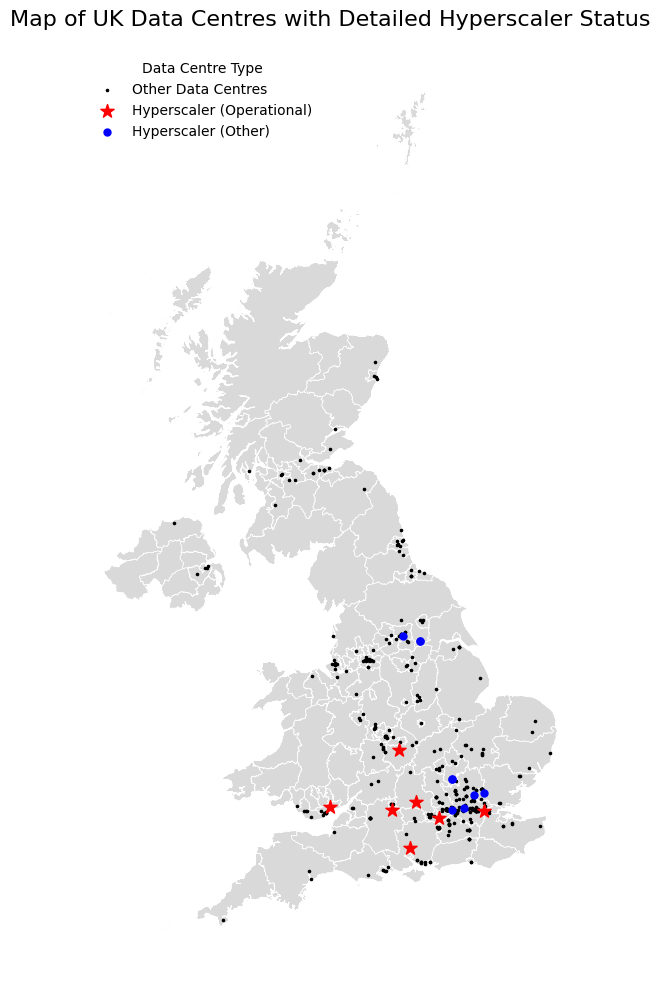

In [31]:
# Plotting hyperscalers + regular data centres
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

uk_shape_proj.plot(ax=ax, color='#d9d9d9', edgecolor='white', linewidth=0.5)

other_dcs = uk_gdf_proj[uk_gdf_proj['type'] != 'Hyperscaler']
if not other_dcs.empty:
    other_dcs.plot(
        ax=ax,
        color='black',
        marker='o',
        markersize=2.5,
        label='Other Data Centres',
        zorder=2
    )

hyperscaler_op = uk_gdf_proj[(uk_gdf_proj['type'] == 'Hyperscaler') & (uk_gdf_proj['stage'] == 'Operational')]
if not hyperscaler_op.empty:
    hyperscaler_op.plot(
        ax=ax,
        color='red',
        marker='*',
        markersize=100,
        label='Hyperscaler (Operational)',
        zorder=3
    )

hyperscaler_other = uk_gdf_proj[(uk_gdf_proj['type'] == 'Hyperscaler') & (uk_gdf_proj['stage'] != 'Operational')]
if not hyperscaler_other.empty:
    hyperscaler_other.plot(
        ax=ax,
        color='blue',
        marker='o',
        markersize=25,
        label='Hyperscaler (Other)',
        zorder=3
    )

ax.set_title('Map of UK Data Centres with Detailed Hyperscaler Status', fontsize=16)
plt.axis('off')
plt.legend(title='Data Centre Type', frameon=False, loc='upper left')
plt.show()

In [37]:
# Loading the grid development request data
file_path = "/content/drive/My Drive/developments.csv"
developments = pd.read_csv(file_path)

In [43]:
developments_gdf

,ID,LicenceArea,GridSupplyPoint,Substation,SiteFunctionalLocation,Proposed_Connection_Voltage_kV,Status of Connection,Demand_Numbers_Received_Total_Number,Demand_Numbers_Received_Total_Capacity,Generation_Numbers_Received_Total_Number,Generation_Numbers_Received_Total_Capacity,Spatial Coordinates,latitude,longitude,geometry
0,2,Eastern Power Networks (EPN),Amersham,Ilmer Grid 33kV,EPN-S0000000D8077,33.0,Connection offers made (not yet accepted by cu...,NaN,NaN,1.0,25.9,"51.7517773136147, -0.88227449772753",51.751777,-0.882274,POINT (-0.88227 51.75178)
1,25,Eastern Power Networks (EPN),Braintree,Witham Primary 11kV,EPN-S0000000H3054,11.0,"Connection offers made (cancelled, expired, su...",1.0,2.00,NaN,NaN,"51.8090255565549, 0.641891288839091",51.809026,0.641891,POINT (0.64189 51.80903)
2,26,Eastern Power Networks (EPN),Braintree,Witham Primary 11kV,EPN-S0000000H3054,11.0,Connection offers made (not yet accepted by cu...,5.0,9.80,NaN,NaN,"51.8090255565549, 0.641891288839091",51.809026,0.641891,POINT (0.64189 51.80903)
3,81,Eastern Power Networks (EPN),Bramford,Snetterton Primary 11kV,EPN-S0000000H1189,11.0,Connection offers made (not yet accepted by cu...,1.0,2.20,NaN,NaN,"52.4721861472423, 0.95736970635812",52.472186,0.957370,POINT (0.95737 52.47219)
4,82,Eastern Power Networks (EPN),Bramford,Snetterton Primary 11kV,EPN-S0000000H1189,33.0,Budget Estimates Provided,1.0,9.00,NaN,NaN,"52.4721861472423, 0.95736970635812",52.472186,0.957370,POINT (0.95737 52.47219)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
917,884,South Eastern Power Networks (SPN),Northfleet,Ebbsfleet Grid,NaN,33.0,Budget Estimates Provided,1.0,41.75,NaN,NaN,NaN,NaN,NaN,POINT (NaN NaN)
918,887,South Eastern Power Networks (SPN),Richborough,Manston 11kV,SPN-S000000008616,11.0,"Connection offer made (cancelled, expired, sup...",3.0,4.97,NaN,NaN,"51.353037578375, 1.36475273803397",51.353038,1.364753,POINT (1.36475 51.35304)
919,912,South Eastern Power Networks (SPN),West Weybridge,Guildford 'A' 11kV,SPN-S000000008521,11.0,Connection offer made (not yet accepted by cus...,1.0,1.50,NaN,NaN,"51.2459436246394, -0.578257455447134",51.245944,-0.578257,POINT (-0.57826 51.24594)
920,915,South Eastern Power Networks (SPN),West Weybridge,Merrow 11kV,SPN-S000000008435,11.0,"Connection offer made (cancelled, expired, sup...",1.0,1.35,NaN,NaN,"51.2510701377563, -0.545385789244119",51.251070,-0.545386,POINT (-0.54539 51.25107)


In [40]:
# Converting into a spatial object
developments[['latitude', 'longitude']] = developments['Spatial Coordinates'].str.split(',', expand=True)

developments['latitude'] = pd.to_numeric(developments['latitude'])
developments['longitude'] = pd.to_numeric(developments['longitude'])

developments_gdf = gpd.GeoDataFrame(
    developments,
    geometry=gpd.points_from_xy(developments.longitude, developments.latitude)
)

print(f"The CRS of uk_gdf is: {uk_gdf.crs}")
developments_gdf.set_crs(uk_gdf.crs, inplace=True)
print(f"The CRS of developments_gdf is now: {developments_gdf.crs}")

The CRS of uk_gdf is: EPSG:4326
The CRS of developments_gdf is now: EPSG:4326


In [44]:
# Join
developments_with_substations = gpd.sjoin_nearest(developments_gdf, uk_gdf)

/usr/local/lib/python3.12/dist-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


In [59]:
uk_gdf

,name,id,parent_id,company_name,company_id,stage,type,latitude,longitude,address,postal,city,market,state,country,power_mw,pue,year_operational,geometry
0,Redhill Data Centre Campus - Building 1,11700,12932.0,Galaxy Data Centers,12696,Operational,Colocation,51.247775,-0.159748,1 St Annes Blvd,RH1 1PP,Redhill,London,NaN,United Kingdom,NaN,NaN,NaN,POINT (-0.15975 51.24778)
1,Redhill Data Centre Campus - Building 2,11699,12932.0,Galaxy Data Centers,12696,Operational,Colocation,51.247665,-0.158616,2 St Annes Blvd,RH1 1AX,Redhill,London,NaN,United Kingdom,1.4,NaN,NaN,POINT (-0.15862 51.24766)
2,45 Maylands Avenue,15164,0.0,NorthTree Investment Management,13325,Planned,Colocation,51.761732,-0.439218,45 Maylands Ave,HP2 7BW,Hemel Hempstead,London,NaN,United Kingdom,10.0,NaN,NaN,POINT (-0.43922 51.76173)
3,Prescient Data Centres,7656,0.0,Prescient Data Centres,8558,Operational,Colocation,55.153207,-6.685766,Atlantic Link Enterprise Campus,BT52 1FA,Coleraine,Belfast,NaN,United Kingdom,4.5,NaN,2018.0,POINT (-6.68577 55.15321)
4,630 Ajax Ave (LHR26),11702,0.0,Digital Realty,419,Operational,Colocation,51.516500,-0.617904,630 Ajax Ave,SL1 4DG,Slough,London,NaN,United Kingdom,9.0,NaN,NaN,POINT (-0.6179 51.5165)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,WRN Broadcast Data Centre,3063,0.0,WRN Broadcast,1977,Operational,Colocation,51.481669,-0.125997,"Wyvil Court, 10 Wyvil Rd",SW8 2TG,London,London,London,United Kingdom,NaN,NaN,NaN,POINT (-0.126 51.48167)
480,Yondr London - Building 1,12052,14302.0,Yondr Group,12082,Operational,Colocation,51.512496,-0.579722,1 Petersfield Ave,SL2 5EA,Slough,London,NaN,United Kingdom,30.0,NaN,2022.0,POINT (-0.57972 51.5125)
481,Yondr London - Building 2,14300,14302.0,Yondr Group,12082,Operational,Colocation,51.512889,-0.578293,1 Petersfield Ave,SL2 5EA,Slough,London,NaN,United Kingdom,30.0,NaN,NaN,POINT (-0.57829 51.51289)
482,Yondr London - Building 3,14301,14302.0,Yondr Group,12082,Under Construction,Colocation,51.512950,-0.575891,1 Petersfield Ave,SL2 5EA,Slough,London,NaN,United Kingdom,40.0,NaN,NaN,POINT (-0.57589 51.51295)


In [60]:
developments_with_substations.head()

,ID,LicenceArea,GridSupplyPoint,Substation,SiteFunctionalLocation,Proposed_Connection_Voltage_kV,Status of Connection,Demand_Numbers_Received_Total_Number,Demand_Numbers_Received_Total_Capacity,Generation_Numbers_Received_Total_Number,Generation_Numbers_Received_Total_Capacity,Spatial Coordinates,latitude_left,longitude_left,geometry,index_right,name,id,parent_id,company_name,company_id,stage,type,latitude_right,longitude_right,address,postal,city,market,state,country,power_mw,pue,year_operational
0,2,Eastern Power Networks (EPN),Amersham,Ilmer Grid 33kV,EPN-S0000000D8077,33.0,Connection offers made (not yet accepted by cu...,NaN,NaN,1.0,25.9,"51.7517773136147, -0.88227449772753",51.751777,-0.882274,POINT (-0.88227 51.75178),453,VIRTUS LONDON15,14190,14189.0,VIRTUS Data Centres,1478,Planned,Colocation,51.679745,-0.834351,Haw Ln,HP14 4JD,High Wycombe,London,NaN,United Kingdom,9.50,NaN,NaN
1,25,Eastern Power Networks (EPN),Braintree,Witham Primary 11kV,EPN-S0000000H3054,11.0,"Connection offers made (cancelled, expired, su...",1.0,2.0,NaN,NaN,"51.8090255565549, 0.641891288839091",51.809026,0.641891,POINT (0.64189 51.80903),194,European Liquidity Center (EULC),13677,0.0,"Intercontinental Exchange, Inc. (ICE)",12843,Operational,Colocation,51.586666,0.484857,20-315 Cranes Farm Rd,SS14 3DF,Basildon,London,NaN,United Kingdom,3.00,NaN,NaN
2,26,Eastern Power Networks (EPN),Braintree,Witham Primary 11kV,EPN-S0000000H3054,11.0,Connection offers made (not yet accepted by cu...,5.0,9.8,NaN,NaN,"51.8090255565549, 0.641891288839091",51.809026,0.641891,POINT (0.64189 51.80903),194,European Liquidity Center (EULC),13677,0.0,"Intercontinental Exchange, Inc. (ICE)",12843,Operational,Colocation,51.586666,0.484857,20-315 Cranes Farm Rd,SS14 3DF,Basildon,London,NaN,United Kingdom,3.00,NaN,NaN
3,81,Eastern Power Networks (EPN),Bramford,Snetterton Primary 11kV,EPN-S0000000H1189,11.0,Connection offers made (not yet accepted by cu...,1.0,2.2,NaN,NaN,"52.4721861472423, 0.95736970635812",52.472186,0.957370,POINT (0.95737 52.47219),336,NorwichDC,15130,0.0,NorwichDC,13317,Operational,Colocation,52.486675,1.221099,"Unit 12 Salamanca Rd, Norwich NR152P",NR152P,Norwich,Norwich,Norfolk,United Kingdom,0.25,NaN,2025.0
4,82,Eastern Power Networks (EPN),Bramford,Snetterton Primary 11kV,EPN-S0000000H1189,33.0,Budget Estimates Provided,1.0,9.0,NaN,NaN,"52.4721861472423, 0.95736970635812",52.472186,0.957370,POINT (0.95737 52.47219),336,NorwichDC,15130,0.0,NorwichDC,13317,Operational,Colocation,52.486675,1.221099,"Unit 12 Salamanca Rd, Norwich NR152P",NR152P,Norwich,Norwich,Norfolk,United Kingdom,0.25,NaN,2025.0


In [48]:
# Filtering by suitable threshold for (hopefully) identifying data centre expansion/development requests
threshold_mva = 30

significant_developments = developments_with_substations[
    developments_with_substations['Proposed_Connection_Voltage_kV'] > threshold_mva
].copy()

print(f"Found {len(significant_developments)} potential large-scale developments.")

Found 181 potential large-scale developments.


In [50]:
# Cleaning
if 'index_right' in significant_developments.columns:
    significant_developments.rename(columns={'index_right': 'original_index_right'}, inplace=True)
if 'index_right' in uk_shape.columns:
    uk_shape.rename(columns={'index_right': 'original_index_right'}, inplace=True)

developments_by_la = gpd.sjoin(significant_developments, uk_shape, how="inner", predicate="within")

In [57]:
# Changing table display
pd.set_option('display.max_columns', None)

developments_by_la.head()

,ID,LicenceArea,GridSupplyPoint,Substation,SiteFunctionalLocation,Proposed_Connection_Voltage_kV,Status of Connection,Demand_Numbers_Received_Total_Number,Demand_Numbers_Received_Total_Capacity,Generation_Numbers_Received_Total_Number,Generation_Numbers_Received_Total_Capacity,Spatial Coordinates,latitude_left,longitude_left,geometry,original_index_right,name,id,parent_id,company_name,company_id,stage,type,latitude_right,longitude_right,address,postal,city,market,state,country,power_mw,pue,year_operational,index_right,GID_2,GID_0,COUNTRY,GID_1,NAME_1,NL_NAME_1,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2
0,2,Eastern Power Networks (EPN),Amersham,Ilmer Grid 33kV,EPN-S0000000D8077,33.0,Connection offers made (not yet accepted by cu...,NaN,NaN,1.0,25.9,"51.7517773136147, -0.88227449772753",51.751777,-0.882274,POINT (-0.88227 51.75178),453,VIRTUS LONDON15,14190,14189.0,VIRTUS Data Centres,1478,Planned,Colocation,51.679745,-0.834351,Haw Ln,HP14 4JD,High Wycombe,London,NaN,United Kingdom,9.50,NaN,NaN,60,GBR.1.13_1,GBR,United Kingdom,GBR.1_1,England,NA,NA,NA,NA,NA,NA,NA,GB.BU
4,82,Eastern Power Networks (EPN),Bramford,Snetterton Primary 11kV,EPN-S0000000H1189,33.0,Budget Estimates Provided,1.0,9.0,NaN,NaN,"52.4721861472423, 0.95736970635812",52.472186,0.957370,POINT (0.95737 52.47219),336,NorwichDC,15130,0.0,NorwichDC,13317,Operational,Colocation,52.486675,1.221099,"Unit 12 Salamanca Rd, Norwich NR152P",NR152P,Norwich,Norwich,Norfolk,United Kingdom,0.25,NaN,2025.0,88,GBR.1.59_1,GBR,United Kingdom,GBR.1_1,England,NA,NA,NA,NA,Administrative County,Administrative County,NA,GB.NF
5,94,Eastern Power Networks (EPN),Bramford,Tivetshall Primary 11kV,EPN-S0000000H1033,33.0,Connection offers made (not yet accepted by cu...,NaN,NaN,1.0,30.0,"52.4401378458545, 1.17358086562589",52.440138,1.173581,POINT (1.17358 52.44014),336,NorwichDC,15130,0.0,NorwichDC,13317,Operational,Colocation,52.486675,1.221099,"Unit 12 Salamanca Rd, Norwich NR152P",NR152P,Norwich,Norwich,Norfolk,United Kingdom,0.25,NaN,2025.0,88,GBR.1.59_1,GBR,United Kingdom,GBR.1_1,England,NA,NA,NA,NA,Administrative County,Administrative County,NA,GB.NF
13,263,Eastern Power Networks (EPN),Norwich,Norwich Main 132kV,EPN-S0000000C5012,132.0,Budget Estimates Provided,NaN,NaN,5.0,549.9,"52.5740279616305, 1.27181803305154",52.574028,1.271818,POINT (1.27182 52.57403),206,FreeClix Data Centre,6215,0.0,FreeClix Ltd,4853,Operational,Colocation,52.629473,1.296997,28 Castle Meadow,NR1 3DS,Norwich,Norwich,Norfolk,United Kingdom,NaN,NaN,2010.0,88,GBR.1.59_1,GBR,United Kingdom,GBR.1_1,England,NA,NA,NA,NA,Administrative County,Administrative County,NA,GB.NF
16,290,Eastern Power Networks (EPN),Pelham,Belchamp Grid 33kV,EPN-S0000000D1011,33.0,Connection offers made (not yet accepted by cu...,NaN,NaN,2.0,66.1,"52.0685789944063, 0.605358966326239",52.068579,0.605359,POINT (0.60536 52.06858),105,SDC Colchester Data Centre,8282,0.0,SDC Hosting and Support,9910,Operational,Colocation,51.923767,0.921581,890 The Crescent,CO49YQ,Colchester,Colchester,ESSEX,United Kingdom,NaN,NaN,2020.0,75,GBR.1.33_1,GBR,United Kingdom,GBR.1_1,England,NA,NA,NA,NA,Administrative County,Administrative County,NA,GB.EX


In [56]:
developments_by_la

,ID,LicenceArea,GridSupplyPoint,Substation,SiteFunctionalLocation,Proposed_Connection_Voltage_kV,Status of Connection,Demand_Numbers_Received_Total_Number,Demand_Numbers_Received_Total_Capacity,Generation_Numbers_Received_Total_Number,...,GID_1,NAME_1,NL_NAME_1,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2
0,2,Eastern Power Networks (EPN),Amersham,Ilmer Grid 33kV,EPN-S0000000D8077,33.0,Connection offers made (not yet accepted by cu...,NaN,NaN,1.0,...,GBR.1_1,England,NA,NA,NA,NA,NA,NA,NA,GB.BU
4,82,Eastern Power Networks (EPN),Bramford,Snetterton Primary 11kV,EPN-S0000000H1189,33.0,Budget Estimates Provided,1.0,9.0,NaN,...,GBR.1_1,England,NA,NA,NA,NA,Administrative County,Administrative County,NA,GB.NF
5,94,Eastern Power Networks (EPN),Bramford,Tivetshall Primary 11kV,EPN-S0000000H1033,33.0,Connection offers made (not yet accepted by cu...,NaN,NaN,1.0,...,GBR.1_1,England,NA,NA,NA,NA,Administrative County,Administrative County,NA,GB.NF
13,263,Eastern Power Networks (EPN),Norwich,Norwich Main 132kV,EPN-S0000000C5012,132.0,Budget Estimates Provided,NaN,NaN,5.0,...,GBR.1_1,England,NA,NA,NA,NA,Administrative County,Administrative County,NA,GB.NF
16,290,Eastern Power Networks (EPN),Pelham,Belchamp Grid 33kV,EPN-S0000000D1011,33.0,Connection offers made (not yet accepted by cu...,NaN,NaN,2.0,...,GBR.1_1,England,NA,NA,NA,NA,Administrative County,Administrative County,NA,GB.EX
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
872,583,London Power Networks (LPN),City Road,Finsbury Mkt F 33kV,LPN-S000000003433,33.0,Budget Estimates Provided,1.0,4.0,NaN,...,GBR.1_1,England,NA,NA,NA,NA,NA,NA,NA,GB.GL
901,771,South Eastern Power Networks (SPN),Bolney,Bolney 132kV,SPN-S000000009905,132.0,Budget Estimates Provided,1.0,100.0,NaN,...,GBR.1_1,England,NA,West Sussex,NA,NA,Administrative County,Administrative County,NA,GB.WS
901,771,South Eastern Power Networks (SPN),Bolney,Bolney 132kV,SPN-S000000009905,132.0,Budget Estimates Provided,1.0,100.0,NaN,...,GBR.1_1,England,NA,West Sussex,NA,NA,Administrative County,Administrative County,NA,GB.WS
911,845,South Eastern Power Networks (SPN),Ninfield,Hartley Grid 33kV,SPN-S000000009122,33.0,"Connection offer made (cancelled, expired, sup...",NaN,NaN,1.0,...,GBR.1_1,England,NA,Kent,NA,NA,Administrative County,Administrative County,NA,GB.KE


In [61]:
# Applying threshold again
threshold_mva = 30
significant_developments = developments_with_substations[
    developments_with_substations['Demand_Numbers_Received_Total_Capacity'] > threshold_mva
].copy()

print(f"Found {len(significant_developments)} potential large-scale developments based on capacity.")


Found 45 potential large-scale developments based on capacity.


In [64]:
# Rename the column to reflect its origin
significant_developments.rename(columns={'index_right': 'original_uk_gdf_index'}, inplace=True)

In [86]:
significant_developments

,ID,LicenceArea,GridSupplyPoint,Substation,SiteFunctionalLocation,Proposed_Connection_Voltage_kV,Status of Connection,Demand_Numbers_Received_Total_Number,Demand_Numbers_Received_Total_Capacity,Generation_Numbers_Received_Total_Number,Generation_Numbers_Received_Total_Capacity,Spatial Coordinates,latitude_left,longitude_left,geometry,original_uk_gdf_index,name,id,parent_id,company_name,company_id,stage,type,latitude_right,longitude_right,address,postal,city,market,state,country,power_mw,pue,year_operational
30,491,Eastern Power Networks (EPN),Warley,Purfleet Grid 33kV,EPN-S0000000D7049,33.0,Budget Estimates Provided,2.0,32.5,NaN,NaN,"51.4785511205189, 0.261893054480452",51.478551,0.261893,POINT (0.26189 51.47855),207,Fujitsu UK London East (SDC01),13675,0.0,Fujitsu,3126,Operational,Colocation,51.481291,0.270250,"Units 2, 5 Weston Ave",RM20 3FJ,Grays,Essex,NaN,United Kingdom,4.65,NaN,NaN
67,165,Eastern Power Networks (EPN),Eaton Socon,Eaton Socon Grid 132kV,EPN-S0000000C4076,132.0,Budget Estimates Provided,1.0,600.0,NaN,NaN,"52.2147364575905, -0.301694937097924",52.214736,-0.301695,POINT (-0.30169 52.21474),238,i-Dash Data Center,5105,0.0,i-Dash Ltd,3867,Operational,Colocation,52.213125,-0.290844,105 Great North Road,PE19 8EL,St Neots,Cambridge,NaN,United Kingdom,NaN,NaN,2014.0
108,512,Eastern Power Networks (EPN),Watford South,Watford South 132kV,EPN-S0000000C8171,132.0,Budget Estimates Provided,1.0,50.0,NaN,NaN,"51.642704737748, -0.404651376833844",51.642705,-0.404651,POINT (-0.40465 51.6427),431,The Chess Building,7822,0.0,CapitaLand Data Centre,8510,Operational,Colocation,51.643272,-0.428110,"The Chess Building, 9-17 Caxton Way",WD18 8UA,Watford,London,NaN,United Kingdom,31.00,NaN,2008.0
141,69,Eastern Power Networks (EPN),Bramford,Lawford Grid 33kV,EPN-S0000000D3048,33.0,Budget Estimates Provided,1.0,37.4,1.0,25.0,"51.9166367025341, 1.01869819169731",51.916637,1.018698,POINT (1.0187 51.91664),365,Broadbent Group Data Centre,8588,0.0,Broadbent Group Ltd,10373,Operational,Colocation,51.928071,0.941695,Turnpike Close,CO7 7QW,Colchester,Colchester,Essex,United Kingdom,NaN,NaN,2021.0
150,191,Eastern Power Networks (EPN),Elstree,Bushey Mill Grid 33kV,EPN-S0000000D8006,132.0,Budget Estimates Provided,1.0,50.0,NaN,NaN,"51.670976638723, -0.382370800818844",51.670977,-0.382371,POINT (-0.38237 51.67098),56,Ark Data Centres - Elstree Campus,14249,0.0,Ark Data Centres,8201,Planned,Campus,51.657632,-0.348619,A41 Watford-by-pass,WD25 8JH,Watford,London,NaN,United Kingdom,200.00,NaN,NaN
151,196,Eastern Power Networks (EPN),Elstree,Elstree GIS 132kV,EPN-S0000000C8245,132.0,Connection offers made (not yet accepted by cu...,1.0,200.0,NaN,NaN,"51.6591401724472, -0.342180028458686",51.659140,-0.342180,POINT (-0.34218 51.65914),56,Ark Data Centres - Elstree Campus,14249,0.0,Ark Data Centres,8201,Planned,Campus,51.657632,-0.348619,A41 Watford-by-pass,WD25 8JH,Watford,London,NaN,United Kingdom,200.00,NaN,NaN
164,351,Eastern Power Networks (EPN),Rye House,Rye House Grid 33kV,EPN-S0000000D7015,33.0,"Connection offers made (cancelled, expired, su...",3.0,50.2,NaN,NaN,"51.7580295556759, 0.00389214056568798",51.758030,0.003892,POINT (0.00389 51.75803),410,SUB1 North London Data Centre,13847,0.0,SUB1 Data Centres,12885,Operational,Colocation,51.759147,-0.000264,5 Bingley Rd,EN11 0BU,Hoddesdon,London,NaN,United Kingdom,14.30,1.075,2024.0
178,437,Eastern Power Networks (EPN),Walpole,Great Haddon Primary 11kV,EPN-S0000000G6026,33.0,"Connection offers made (cancelled, expired, su...",1.0,39.5,NaN,NaN,"52.5359787252294, -0.3003399571397",52.535979,-0.300340,POINT (-0.30034 52.53598),170,DSM Eco Data Centre,6444,0.0,MyHostingSpace - DSM Group,5302,Operational,Colocation,52.554309,-0.390878,"The Old Hangar, Elton Road",PE8 6NE,Peterborough,Peterborough,Cambridgeshire,United Kingdom,2.00,NaN,2004.0
215,35,Eastern Power Networks (EPN),Bramford,Bramford Grid 132kV,EPN-S0000000C1068,132.0,Connection offers made (not yet accepted by cu...,2.0,250.0,1.0,50.0,"52.07

In [93]:
# Getting count of developments per local authority
developments_by_la1 = gpd.sjoin(significant_developments, uk_shape, how="inner", predicate="within")


In [94]:
developments_by_la1

,ID,LicenceArea,GridSupplyPoint,Substation,SiteFunctionalLocation,Proposed_Connection_Voltage_kV,Status of Connection,Demand_Numbers_Received_Total_Number,Demand_Numbers_Received_Total_Capacity,Generation_Numbers_Received_Total_Number,Generation_Numbers_Received_Total_Capacity,Spatial Coordinates,latitude_left,longitude_left,geometry,original_uk_gdf_index,name,id,parent_id,company_name,company_id,stage,type,latitude_right,longitude_right,address,postal,city,market,state,country,power_mw,pue,year_operational,index_right,LAD23CD,LAD23NM,LAD23NMW,BNG_E,BNG_N,LONG,LAT,GlobalID
30,491,Eastern Power Networks (EPN),Warley,Purfleet Grid 33kV,EPN-S0000000D7049,33.0,Budget Estimates Provided,2.0,32.5,NaN,NaN,"51.4785511205189, 0.261893054480452",51.478551,0.261893,POINT (557170.001 177936),207,Fujitsu UK London East (SDC01),13675,0.0,Fujitsu,3126,Operational,Colocation,51.481291,0.270250,"Units 2, 5 Weston Ave",RM20 3FJ,Grays,Essex,NaN,United Kingdom,4.65,NaN,NaN,31,E06000034,Thurrock,None,562124,181588,0.334874,51.5100,c618d3be-c2b7-405b-82b7-1812d3e66a18
67,165,Eastern Power Networks (EPN),Eaton Socon,Eaton Socon Grid 132kV,EPN-S0000000C4076,132.0,Budget Estimates Provided,1.0,600.0,NaN,NaN,"52.2147364575905, -0.301694937097924",52.214736,-0.301695,POINT (516127.001 258750),238,i-Dash Data Center,5105,0.0,i-Dash Ltd,3867,Operational,Colocation,52.213125,-0.290844,105 Great North Road,PE19 8EL,St Neots,Cambridge,NaN,United Kingdom,NaN,NaN,2014.0,51,E06000055,Bedford,None,505721,256463,-0.454630,52.1963,234a0011-f028-44c0-b0be-5fbc562c734d
108,512,Eastern Power Networks (EPN),Watford South,Watford South 132kV,EPN-S0000000C8171,132.0,Budget Estimates Provided,1.0,50.0,NaN,NaN,"51.642704737748, -0.404651376833844",51.642705,-0.404651,POINT (510488.001 194972),431,The Chess Building,7822,0.0,CapitaLand Data Centre,8510,Operational,Colocation,51.643272,-0.428110,"The Chess Building, 9-17 Caxton Way",WD18 8UA,Watford,London,NaN,United Kingdom,31.00,NaN,2008.0,122,E07000102,Three Rivers,None,507313,196418,-0.450050,51.6563,a9dc12a7-acf1-406a-9b28-d3d2f425a373
141,69,Eastern Power Networks (EPN),Bramford,Lawford Grid 33kV,EPN-S0000000D3048,33.0,Budget Estimates Provided,1.0,37.4,1.0,25.0,"51.9166367025341, 1.01869819169731",51.916637,1.018698,POINT (607700.001 228540),365,Broadbent Group Data Centre,8588,0.0,Broadbent Group Ltd,10373,Operational,Colocation,51.928071,0.941695,Turnpike Close,CO7 7QW,Colchester,Colchester,Essex,United Kingdom,NaN,NaN,2021.0,99,E07000076,Tendring,None,614190,222141,1.108980,51.8567,b0c0344a-00c4-4266-9876-3c0b9c2d9f88
150,191,Eastern Power Networks (EPN),Elstree,Bushey Mill Grid 33kV,EPN-S0000000D8006,132.0,Budget Estimates Provided,1.0,50.0,NaN,NaN,"51.670976638723, -0.382370800818844",51.670977,-0.382371,POINT (511960.001 198150),56,Ark Data Centres - Elstree Campus,14249,0.0,Ark Data Centres,8201,Planned,Campus,51.657632,-0.348619,A41 Watford-by-pass,WD25 8JH,Watford,London,NaN,United Kingdom,200.00,NaN,NaN,123,E07000103,Watford,None,510441,198197,-0.404290,51.6717,e16605f2-a114-4e59-a93c-10cf052a2831
151,196,Eastern Power Networks (EPN),Elstree,Elstree GIS 132kV,EPN-S0000000C8245,132.0,Connection offers made (not yet accepted by cu...,1.0,200.0,NaN,NaN,"51.6591401724472, -0.342180028458686",51.659140,-0.342180,POINT (514769.001 196896),56,Ark Data Centres - Elstree Campus,14249,0.0,Ark Data Centres,8201,Planned,Campus,51.657632,-0.348619,A41 Watford-by-pass,WD25 8JH,Watford,London,NaN,United Kingdom,200.00,NaN,NaN,120,E07000098,Hertsmere,None,519774,199352,-0.268990,51.6802,138ba795-d163-4f70-bb4f-210f1eb3a87c
164,351,Eastern Power Networks (EPN),Rye House,Rye House Grid 33kV,EPN-S0000000D7015,33.0,"Connection offers made (cancelled, expired, su...",3.0,50.2,NaN,NaN,"51.7580295556759, 0.00389214056568798",51.758030,0.003892,POINT (538403.001 208493),410,SUB1 North London Data Centre,13847,0.0,SUB1 Data Centres,12885,Operational,Colocation,51.759147,-0.000264,5 Bingley Rd,EN11 0BU,Hoddesdon,London,NaN,United Ki

In [95]:
# Top 10 hotspots for capacity pressure
la_name_column = 'LAD23NM'
capacity_column = 'Demand_Numbers_Received_Total_Capacity'

# Group by local authority and calculate the count and total capacity
hotspots = developments_by_la1.groupby(la_name_column).agg(
    development_count=('geometry', 'count'),
    total_new_capacity_mva=(capacity_column, 'sum')
).sort_values(by='development_count', ascending=False)

# Display the top 10
print("--- Top 10 Local Authority Hotspots for Future Grid Pressure ---")
print(hotspots.head(10))

--- Top 10 Local Authority Hotspots for Future Grid Pressure ---
                      development_count  total_new_capacity_mva
LAD23NM                                                        
Bedford                               4                   914.0
Central Bedfordshire                  3                   450.0
South Cambridgeshire                  3                   190.0
Havering                              3                   545.0
South Norfolk                         3                   364.4
Greenwich                             2                   170.0
East Hertfordshire                    2                  2050.0
Enfield                               2                   450.0
Thurrock                              2                    77.5
Watford                               2                    96.0


In [119]:
hotspots

,development_count,total_new_capacity_mva
LAD23NM,,
Bedford,4,914.0
Central Bedfordshire,3,450.0
South Cambridgeshire,3,190.0
Havering,3,545.0
South Norfolk,3,364.4
Greenwich,2,170.0
East Hertfordshire,2,2050.0
Enfield,2,450.0
Thurrock,2,77.5


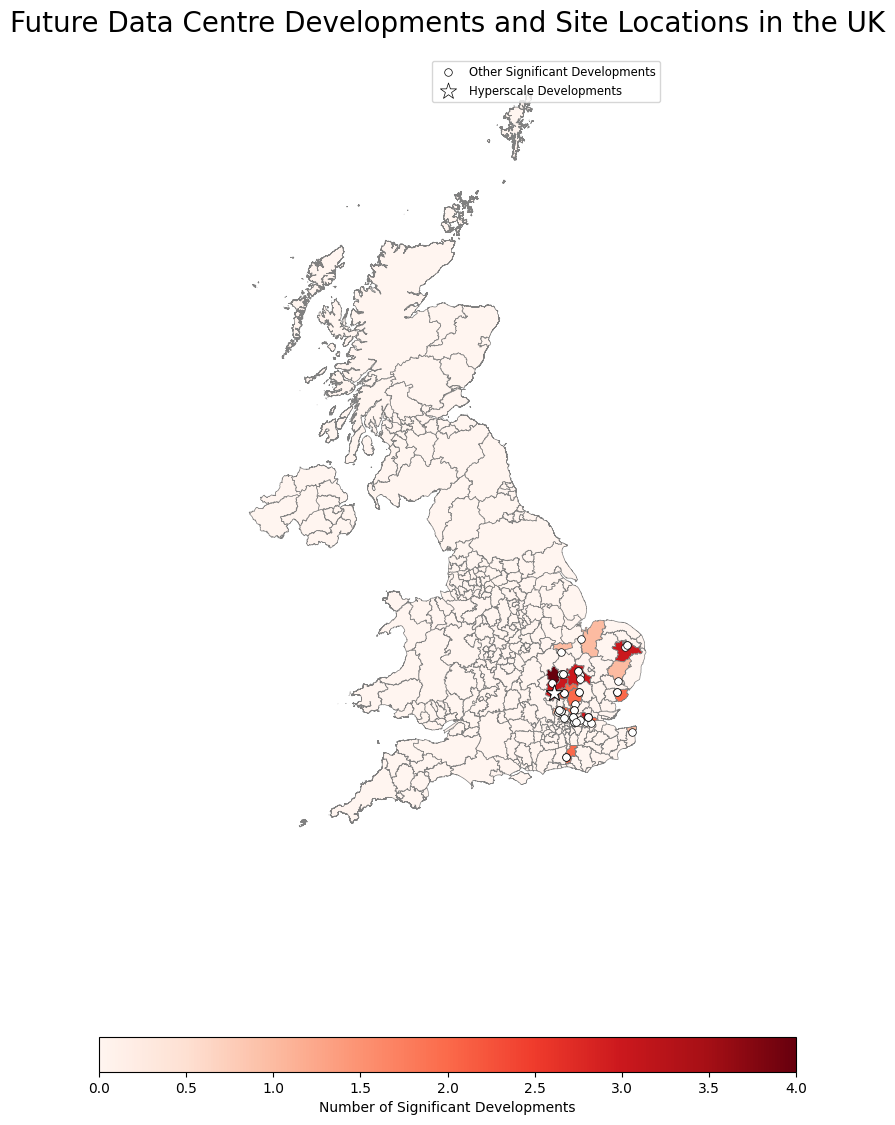

In [116]:
# Plotting developments with data centre location overlay
uk_shape_with_hotspots = uk_shape.merge(hotspots, left_on='LAD23NM', right_index=True, how='left')
uk_shape_with_hotspots['development_count'] = uk_shape_with_hotspots['development_count'].fillna(0)

hyperscalers_gdf = developments_by_la1[developments_by_la1['type'] == 'Hyperscaler'].copy()
other_dcs_gdf = developments_by_la1[developments_by_la1['type'] != 'Hyperscale'].copy()

fig, ax = plt.subplots(1, 1, figsize=(15, 15))

# Layer 1 - chloropleth
uk_shape_with_hotspots.plot(
    column='development_count',
    ax=ax,
    cmap='Reds',
    linewidth=0.5,
    edgecolor='0.5',
    legend=True,
    legend_kwds={
        'label': "Number of Significant Developments",
        'orientation': "horizontal",
        'shrink': 0.6
    }
)

# Layer 2 - data centre points
other_dcs_gdf.plot(
    ax=ax,
    marker='o',
    color='white',
    edgecolor='black',
    linewidth=0.5,
    markersize=30,
    label='Other Significant Developments'
)

hyperscalers_gdf.plot(
    ax=ax,
    marker='*',
    color='white',
    edgecolor='black',
    linewidth=0.5,
    markersize=150,
    label='Hyperscale Developments'
)

ax.set_title('Future Data Centre Developments and Site Locations in the UK', fontdict={'fontsize': '20', 'fontweight': '3'})
ax.set_axis_off()

ax.legend(fontsize='small')
plt.show()

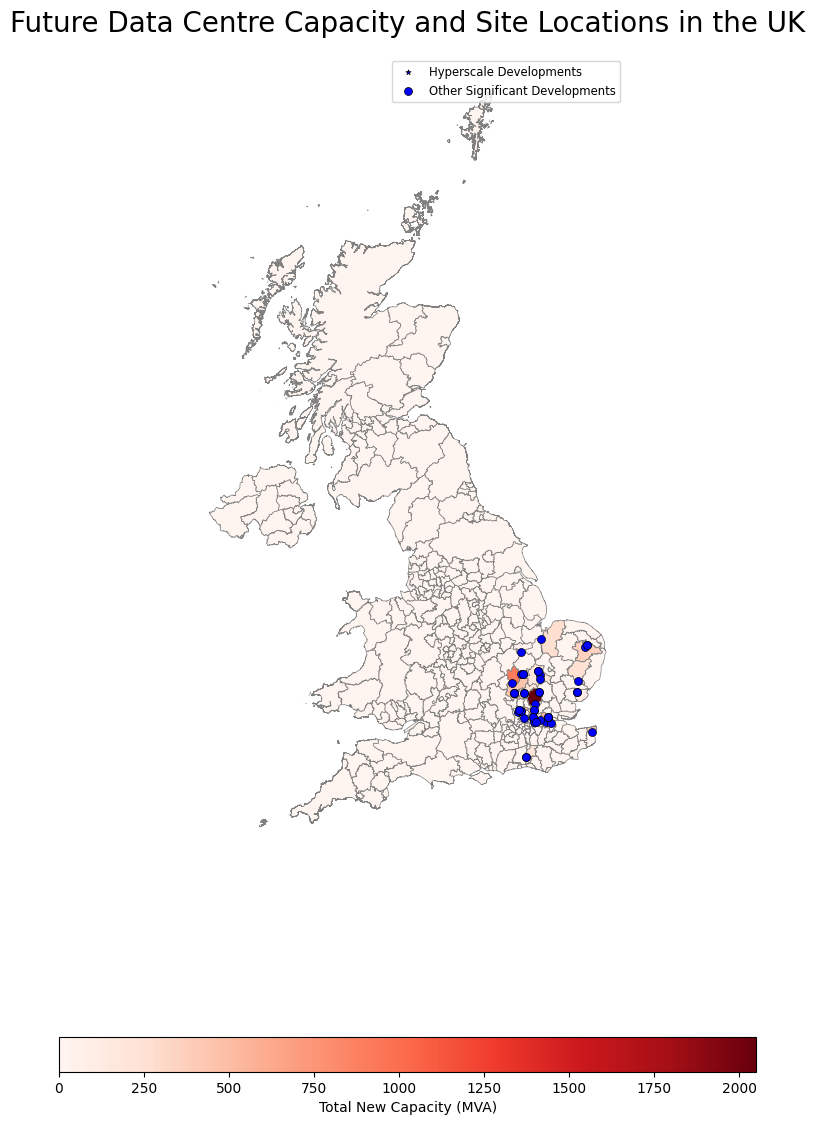

In [124]:
# Plotting total capacity change with data centre location overlay
import matplotlib.pyplot as plt

uk_shape_with_hotspots = uk_shape.merge(hotspots, left_on='LAD23NM', right_index=True, how='left')

uk_shape_with_hotspots['development_count'] = uk_shape_with_hotspots['development_count'].fillna(0)
uk_shape_with_hotspots['total_new_capacity_mva'] = uk_shape_with_hotspots['total_new_capacity_mva'].fillna(0)


hyperscalers_gdf = developments_by_la1[developments_by_la1['type'] == 'Hyperscaler'].copy()
other_dcs_gdf = developments_by_la1[developments_by_la1['type'] != 'Hyperscale'].copy()

fig, ax = plt.subplots(1, 1, figsize=(15, 15))

# Layer 1 - chloropleth
uk_shape_with_hotspots.plot(
    column='total_new_capacity_mva',
    ax=ax,
    cmap='Reds',
    linewidth=0.5,
    edgecolor='0.5',
    legend=True,
    legend_kwds={
        'label': "Total New Capacity (MVA)",
        'orientation': "horizontal",
        'shrink': 0.6
    }
)

# Layer 2 - data centre points
hyperscalers_gdf.plot(
    ax=ax,
    marker='*',
    color='blue',
    edgecolor='black',
    linewidth=0.5,
    markersize=15,
    label='Hyperscale Developments'
)

other_dcs_gdf.plot(
    ax=ax,
    marker='o',
    color='blue',
    edgecolor='black',
    linewidth=0.5,
    markersize=33,
    label='Other Significant Developments'
)

ax.set_title('Future Data Centre Capacity and Site Locations in the UK', fontdict={'fontsize': '20', 'fontweight': '3'})
ax.set_axis_off()
ax.legend(fontsize='small')
plt.show()